# INF 552 - Homework 2

## Shannon Tee, ID 8962768953 

## (a) Combined Cycle Power Plant data from: https://archive.ics.uci.edu/ml/datasets/Combined+Cycle+Power+Plant.

In [195]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing
from sklearn import metrics
from regressors import stats
import statsmodels.api as sma
import statsmodels.formula.api as smf
import warnings

warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

## (b) Exploring the data

In [168]:
cols = ['Temperature', 'Ambient Pressure', 'Relative Humidity', 'Exhaust Vacuum', 'Energy Output']
cols = ['T', 'V', 'AP', 'RH', 'EP']
df = pd.read_excel("Folds5x2_pp.xlsx", names=cols) 
df.head()

,T,V,AP,RH,EP
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


In [169]:
rows = df.shape[0]
columns = df.shape[1]

print('Rows:', rows, '\nColumns:', columns)
print('Each row represents a data point collected from the Combined Cycle Power Plant during 2006-2011')
print('The first four columns are independent variables consisting of hourly average ambient variables, ' 
      'while the last column is a dependent variable predicted from the independent variables.')


Rows: 9568 
Columns: 5
Each row represents a data point collected from the Combined Cycle Power Plant during 2006-2011
The first four columns are independent variables consisting of hourly average ambient variables, while the last column is a dependent variable predicted from the independent variables.


### ii. Pairwise scatterplots of all the varianbles in the data set

<Figure size 432x432 with 0 Axes>

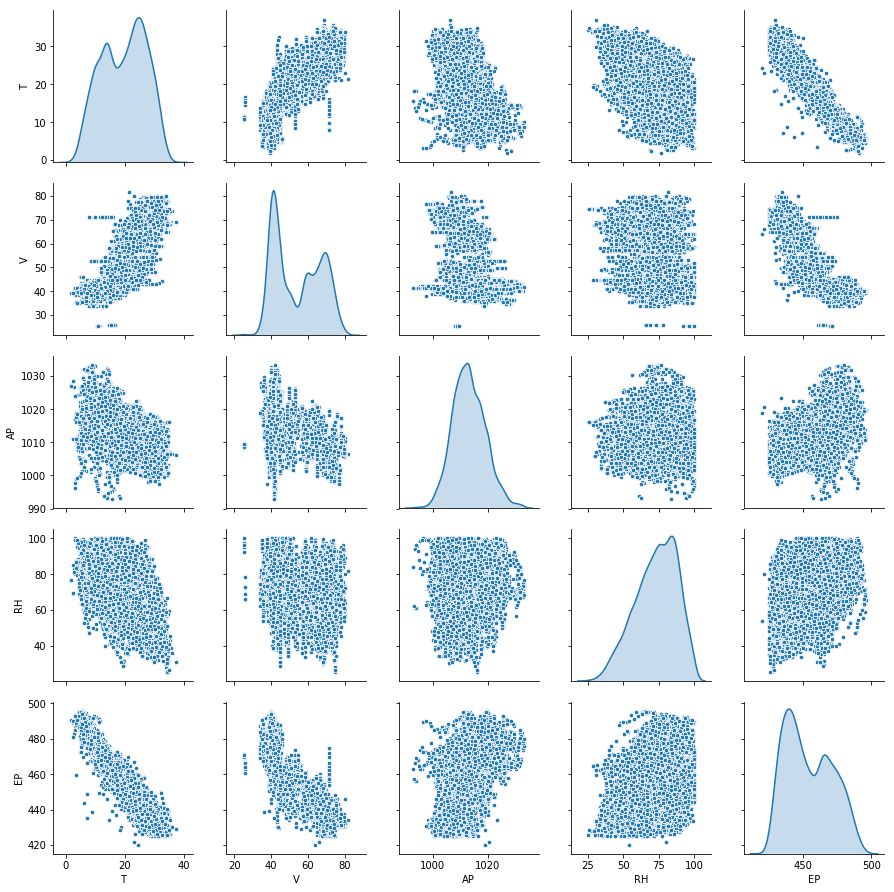

In [133]:
plt.figure(figsize=(6,6))
sns.pairplot(df, diag_kind='kde', plot_kws=dict(s=20))
plt.show()

### iii. Mean, the median, range, first and third quartiles, and interquartile ranges of each variable

In [134]:
describe_df = df.describe()
describe_df = describe_df.transpose()
describe_df.head()
describe_df['range'] = describe_df.apply(lambda x: x['max'] - x['min'], axis=1)
describe_df['IQR'] = describe_df.apply(lambda x: x['75%'] - x['50%'], axis=1)
median_df = df.median().to_frame()
describe_df = pd.merge(describe_df, median_df, on=describe_df.index, how='outer')
describe_df.columns = ['Variable', 'Count', 'Mean', 'Std', 'Min', 'First Quartile', 'Second Quartile', 'Third Quartile', 'Max', 'Range', 'IQR', 'Median']
describe_df = describe_df[['Variable', 'Mean', 'Median', 'Range','First Quartile', 'Third Quartile', 'IQR']]
describe_df = describe_df.round(decimals=3)
describe_df

,Variable,Mean,Median,Range,First Quartile,Third Quartile,IQR
0,T,19.651,20.345,35.30,13.510,25.72,5.375
1,V,54.306,52.080,56.20,41.740,66.54,14.460
2,AP,1013.259,1012.940,40.41,1009.100,1017.26,4.320
3,RH,73.309,74.975,74.60,63.328,84.83,9.855
4,EP,454.365,451.550,75.50,439.750,468.43,16.880


## (c) For each predictor, fit a simple linear regression model to predict the response.



Summary for T:
Residuals:
Min     1Q  Median      3Q      Max
-23.2512 -3.696 -0.1009  3.6436  45.9509


Coefficients:
             Estimate  Std. Error    t value  p value
_intercept  497.03412    0.156268  3180.6524      0.0
x1           -2.17132    0.002941  -738.3933      0.0
---
R-squared:  0.89895,    Adjusted R-squared:  0.89894
F-statistic: 85097.76 on 1 features


Summary for AP:
Residuals:
Min      1Q  Median       3Q      Max
-60.252 -9.8014  3.0086  11.1143  43.7469


Coefficients:
               Estimate  Std. Error   t value  p value
_intercept -1055.260989   25.456818   -41.453      0.0
x1             1.489872    0.000172  8660.426      0.0
---
R-squared:  0.26877,    Adjusted R-squared:  0.26869
F-statistic: 3516.04 on 1 features


Summary for RH:
Residuals:
Min       1Q  Median       3Q      Max
-47.497 -11.9388  1.3681  12.4802  35.9759


Coefficients:
              Estimate  Std. Error   t value  p value
_intercept  420.961766    0.822555  511.7735      0.0
x1     

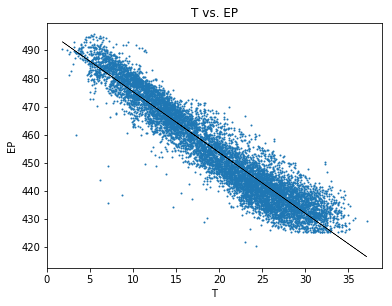

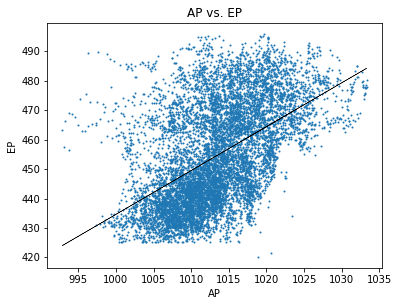

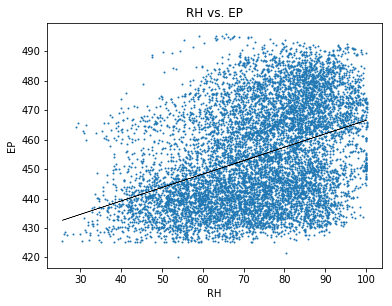

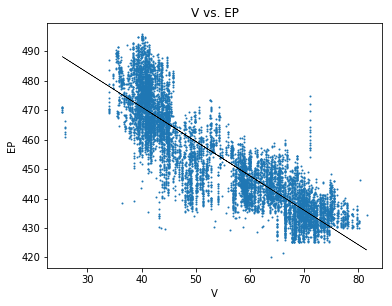

In [170]:
uni_df = pd.DataFrame(columns=['Variable', 'Univariate'])
ind_variables = ['T', 'AP', 'RH', 'V']

i = 0
for variable in ind_variables:
    lm = LinearRegression()
    X = df[variable].values
    X = X.reshape(X.shape[0], 1)
    y = df['EP'].values
    y = y.reshape(y.shape[0], 1)
    lm.fit(X,y)
    uni_df.loc[i] = [variable, lm.coef_[0][0]]
    
    print('\n\nSummary for %s:'%(variable))
    stats.summary(lm, X, y)
    plt.figure(figsize=(6,4.5))
    plt.scatter(x=df[variable].values,y=df['EP'].values, s=1)
    plt.plot(X, lm.predict(X), color='black', linewidth=0.5)
    plt.title(variable + ' vs. EP')
    plt.xlabel(variable)
    plt.ylabel('EP')
    i += 1

Text(0.5, 1.0, 'Temperature vs. Studentized Residuals ')

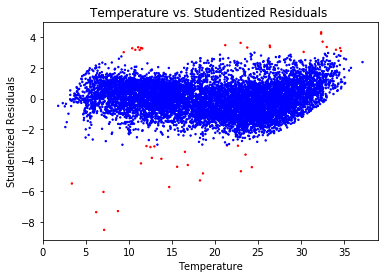

In [136]:
# Find outliers using Studentized Residuals #

X = df['T']
X = sma.add_constant(X)
Y = df['EP']
lm = sm.OLS(Y, X).fit()

lm.summary()
y_pred = lm.predict(X)

influence = lm.get_influence()  
stud_residual = influence.resid_studentized_external
resid = pd.concat([X ,pd.Series(stud_residual,name = "Studentized Residuals")],axis = 1)

resid['outlier'] = resid.apply(lambda x: 1 if (x['Studentized Residuals'] > 3) | (x['Studentized Residuals'] < -3) else 0, axis = 1)
colors = ['blue','red']
plt.scatter(x = resid['T'], y = resid['Studentized Residuals'], c = resid['outlier'], s =2, cmap=plt.cm.bwr)
plt.xlabel('Temperature')
plt.ylabel('Studentized Residuals')
plt.title('Temperature vs. Studentized Residuals ')

Text(0.5, 1.0, 'Exhaust Vacuum vs. Studentized Residuals ')

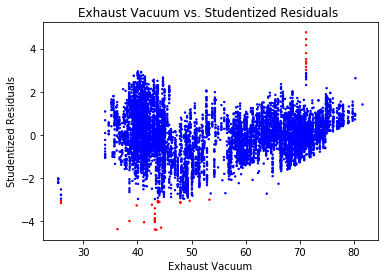

In [137]:
X = df['V']
X = sma.add_constant(X)
Y = df['EP']
lm = sm.OLS(Y, X).fit()

lm.summary()
y_pred = lm.predict(X)
influence = lm.get_influence()  
stud_residual = influence.resid_studentized_external
resid = pd.concat([X ,pd.Series(stud_residual,name = "Studentized Residuals")],axis = 1)

resid['outlier'] = resid.apply(lambda x: 1 if (x['Studentized Residuals'] > 3) | (x['Studentized Residuals'] < -3) else 0, axis = 1)
colors = ['blue','red']
plt.scatter(x = resid['V'], y = resid['Studentized Residuals'], c = resid['outlier'], s =2, cmap=plt.cm.bwr)
plt.xlabel('Exhaust Vacuum')
plt.ylabel('Studentized Residuals')
plt.title('Exhaust Vacuum vs. Studentized Residuals ')


Text(0.5, 1.0, 'Ambient Pressure vs. Studentized Residuals ')

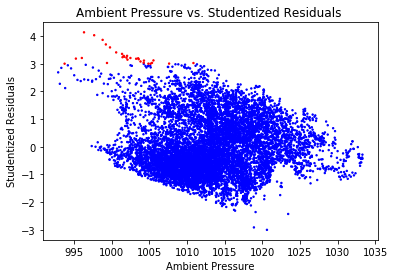

In [138]:
X = df['AP']
X = sma.add_constant(X)
Y = df['EP']
lm = sm.OLS(Y, X).fit()

lm.summary()
y_pred = lm.predict(X)
influence = lm.get_influence()  
stud_residual = influence.resid_studentized_external
resid = pd.concat([X ,pd.Series(stud_residual,name = "Studentized Residuals")],axis = 1)

resid['outlier'] = resid.apply(lambda x: 1 if (x['Studentized Residuals'] > 3) | (x['Studentized Residuals'] < -3) else 0, axis = 1)
colors = ['blue','red']
plt.scatter(x = resid['AP'], y = resid['Studentized Residuals'], c = resid['outlier'], s =2, cmap=plt.cm.bwr)
plt.xlabel('Ambient Pressure')
plt.ylabel('Studentized Residuals')
plt.title('Ambient Pressure vs. Studentized Residuals ')


Text(0.5, 1.0, 'Relative Humidity vs. Studentized Residuals ')

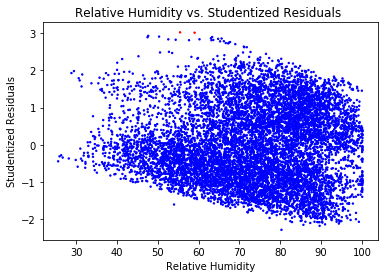

In [139]:
X = df['RH']
X = sma.add_constant(X)
Y = df['EP']
lm = sm.OLS(Y, X).fit()

lm.summary()
y_pred = lm.predict(X)
influence = lm.get_influence()  
stud_residual = influence.resid_studentized_external

resid = pd.concat([X ,pd.Series(stud_residual, name = "Studentized Residuals")],axis = 1)

resid['outlier'] = resid.apply(lambda x: 1 if (x['Studentized Residuals'] > 3) | (x['Studentized Residuals'] < -3) else 0, axis = 1)
colors = ['blue','red']
plt.scatter(x = resid['RH'], y = resid['Studentized Residuals'], c = resid['outlier'], s =2, cmap=plt.cm.bwr)

plt.xlabel('Relative Humidity')
plt.ylabel('Studentized Residuals')
plt.title('Relative Humidity vs. Studentized Residuals ')


In [140]:
# Find outliers using .outlier_test()
predictors = ['T', 'AP', 'RH', 'V']

for variable in predictors:
    X = df[variable]
    X = sma.add_constant(X)
    Y = df['EP']
    lm = sm.OLS(Y, X).fit()

    lm.summary()
    y_pred = lm.predict(X)

    test = lm.outlier_test()

    print(variable)
    for i, t in enumerate(test.iloc[:, 2]):
        if t < 0.5:
            print('(%.3f, %.3f)' %(X[variable].iloc[i], Y.iloc[i]))
    print('\n')

T
(15.610, 439.210)
(11.410, 449.500)
(8.740, 438.630)
(6.220, 443.730)
(14.690, 434.120)
(23.000, 421.570)
(32.310, 450.130)
(16.840, 437.140)
(18.600, 430.380)
(7.060, 448.970)
(7.140, 435.580)
(18.260, 428.670)
(32.310, 449.650)
(3.400, 459.860)
(24.270, 420.260)


AP
(996.320, 489.380)


RH


V
(71.140, 471.990)
(43.210, 430.450)
(71.140, 474.660)
(36.300, 438.630)
(44.370, 429.810)
(43.500, 429.960)
(71.140, 469.640)
(41.220, 435.580)




## (d) Fit a multiple regression model to predict the response using all of the predictors.

In [141]:
multi_df = pd.DataFrame(columns=['Variable', 'Multivariate'])

X = df.iloc[:,0:4]
y = df['EP']
lm = LinearRegression()
lm.fit(X,y)
stats.summary(lm, X, y)

for i in range(0,len(list(X))):
    multi_df.loc[i] = [list(X)[i], lm.coef_[i]]

Residuals:
Min      1Q  Median     3Q      Max
-17.7777 -3.2008  0.1177  3.166  43.4354


Coefficients:
              Estimate  Std. Error   t value  p value
_intercept  454.609274    9.745958   46.6459      0.0
x1           -1.977513    0.012978 -152.3777      0.0
x2           -0.233916    0.005588  -41.8605      0.0
x3            0.062083    0.000088  702.9612      0.0
x4           -0.158054    0.003557  -44.4405      0.0
---
R-squared:  0.92870,    Adjusted R-squared:  0.92867
F-statistic: 31138.27 on 4 features


## (e) Create a plot displaying the univariate and multiple regression coefficients.

Text(0.5, 1.0, 'Comparing Univariate and Multiple Regression Coefficients')

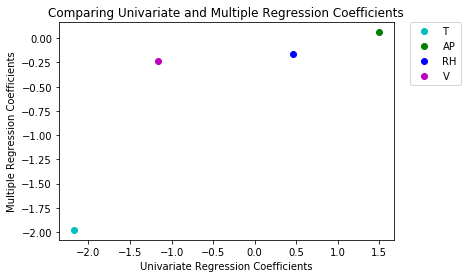

In [142]:
coeff_df = pd.merge(uni_df, multi_df, on='Variable')
coeff_df.head()
c = ["co", "go", "bo", "mo"]

for i in range(0,len(coeff_df.Variable)):
    plt.plot(coeff_df.Univariate.iloc[i], coeff_df.Multivariate.iloc[i], c[i], label=coeff_df.Variable.iloc[i])
plt.legend(bbox_to_anchor = [1.05,1],loc = 2,borderaxespad = 0)
plt.xlabel('Univariate Regression Coefficients')
plt.ylabel('Multiple Regression Coefficients')
plt.title('Comparing Univariate and Multiple Regression Coefficients')

## (f) Evidence of nonlinear association between any of the predictors and the response

In [196]:
# Temperature
f = 'EP ~ T + I(T**2) + I (T**3)'
model = smf.ols(formula=f, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     EP   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                 3.299e+04
Date:                Wed, 06 Feb 2019   Prob (F-statistic):               0.00
Time:                        20:44:02   Log-Likelihood:                -29101.
No. Observations:                9568   AIC:                         5.821e+04
Df Residuals:                    9564   BIC:                         5.824e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    492.7281      0.673    732.248      0.000     491.409     494.047
T             -0.6103      0.124     -4.941      0.000      -0.852      -0.368
I(T ** 2)     -0.1251      0.007    -18.199      0.000      -0.139      -0.112
I(T ** 3)      0.0027      0.000     22.594      0.000       0.002       0.003
==============================================================================
Omnibus:                      648.041   Durbin-Watson:                   2.033
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2767.059
Skew:                          -0.191   Prob(JB):                         0.00
Kurtosis:                       5.607   Cond. No.                     1.90e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.9e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [97]:
# Exhaust Vacuum
f = 'EP ~ V + I(V**2) + I (V**3)'
model = smf.ols(formula=f, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     EP   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                 1.098e+04
Date:                Tue, 05 Feb 2019   Prob (F-statistic):               0.00
Time:                        11:57:11   Log-Likelihood:                -33585.
No. Observations:                9568   AIC:                         6.718e+04
Df Residuals:                    9564   BIC:                         6.721e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    554.1468      9.151     60.557      0.000     536.209     572.084
V             -2.1444      0.509     -4.214      0.000      -3.142      -1.147
I(V ** 2)     -0.0027      0.009     -0.294      0.768      -0.021       0.015
I(V ** 3)      0.0001   5.45e-05      2.465      0.014    2.75e-05       0.000
==============================================================================
Omnibus:                      160.101   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              279.778
Skew:                          -0.125   Prob(JB):                     1.77e-61
Kurtosis:                       3.800   Cond. No.                     2.47e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.47e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [144]:
# Ambient Pressure
f = 'EP ~ AP + I(AP**2) + I (AP**3)'
model = smf.ols(formula=f, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     EP   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     1813.
Date:                Wed, 06 Feb 2019   Prob (F-statistic):               0.00
Time:                        15:25:00   Log-Likelihood:                -39184.
No. Observations:                9568   AIC:                         7.837e+04
Df Residuals:                    9565   BIC:                         7.840e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0747      0.009      8.415      0.000       0.057       0.092
AP            25.2556      3.001      8.415      0.000      19.372      31.139
I(AP ** 2)    -0.0500      0.006     -8.439      0.000      -0.062      -0.038
I(AP ** 3)  2.514e-05   2.92e-06      8.613      0.000    1.94e-05    3.09e-05
==============================================================================
Omnibus:                      556.766   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              640.319
Skew:                           0.621   Prob(JB):                    9.05e-140
Kurtosis:                       2.751   Cond. No.                     2.12e+15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.12e+15. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [145]:
# Relative Humidity
f = 'EP ~ RH + I(RH**2) + I (RH**3)'
model = smf.ols(formula=f, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     EP   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     579.2
Date:                Wed, 06 Feb 2019   Prob (F-statistic):               0.00
Time:                        15:25:45   Log-Likelihood:                -39923.
No. Observations:                9568   AIC:                         7.985e+04
Df Residuals:                    9564   BIC:                         7.988e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    468.4135     10.545     44.422      0.000     447.744     489.083
RH            -1.7292      0.486     -3.557      0.000      -2.682      -0.776
I(RH ** 2)     0.0321      0.007      4.433      0.000       0.018       0.046
I(RH ** 3)    -0.0002   3.51e-05     -4.340      0.000      -0.000   -8.34e-05
==============================================================================
Omnibus:                      707.867   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              302.057
Skew:                           0.223   Prob(JB):                     2.56e-66
Kurtosis:                       2.253   Cond. No.                     3.26e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.26e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## (g) Evidence of association of interactions of predictors with the response

In [171]:
f = 'EP ~ T + V + AP + RH + T * V + T * AP + T * RH + V * AP + V * RH + AP * RH'
model = smf.ols(formula = f, data = df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     EP   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                 1.405e+04
Date:                Wed, 06 Feb 2019   Prob (F-statistic):               0.00
Time:                        20:25:59   Log-Likelihood:                -27548.
No. Observations:                9568   AIC:                         5.512e+04
Df Residuals:                    9557   BIC:                         5.520e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    685.7825     78.640      8.721      0.000     531.631     839.934
T             -4.3470      2.373     -1.832      0.067      -8.999       0.305
V             -7.6749      1.351     -5.682      0.000     -10.323      -5.027
AP            -0.1524      0.077     -1.983      0.047      -0.303      -0.002
RH             1.5709      0.773      2.031      0.042       0.055       3.087
T:V            0.0210      0.001     23.338      0.000       0.019       0.023
T:AP           0.0018      0.002      0.752      0.452      -0.003       0.006
T:RH          -0.0052      0.001     -6.444      0.000      -0.007      -0.004
V:AP           0.0068      0.001      5.135      0.000       0.004       0.009
V:RH           0.0008      0.000      1.716      0.086      -0.000       0.002
AP:RH         -0.0016      0.001     -2.125      0.034      -0.003      -0.000
==============================================================================
Omnibus:                     1454.609   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9170.848
Skew:                          -0.574   Prob(JB):                         0.00
Kurtosis:                       7.657   Cond. No.                     1.70e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.7e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## (h) Improve your model

In [177]:
MSE_df = pd.DataFrame(columns=['Model','MSE'])

In [178]:
X = df[['T', 'V', 'AP', 'RH']]
y = df['EP']

X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.3, random_state = 25)
lm = LinearRegression()
lm.fit(X_train, y_train)
y_train_pred = lm.predict(X_train)
y_test_pred = lm.predict(X_test)
train_MSE = round(metrics.mean_squared_error(y_train, y_train_pred),3)
test_MSE = round(metrics.mean_squared_error(y_test, y_test_pred),3)
print('Multiple Linear Regression Model')
print('Train MSE:', train_MSE)
print('Test MSE:', test_MSE)

MSE_df.loc[0] = ['Multiple Linear Regression - Train', train_MSE]
MSE_df.loc[1] = ['Multiple Linear Regression - Test', test_MSE]

Multiple Linear Regression Model
Train MSE: 20.466
Test MSE: 21.476


In [192]:
# Full linear regression model with all pairwise interaction terms and quadratic nonlinearities
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.3, random_state = 25)

train_df = X_train.merge(y_train.to_frame(), how='outer', left_index=True, right_index=True)
test_df = X_test.merge(y_test.to_frame(), how='outer', left_index=True, right_index=True)

f = 'EP ~ T + V + AP + RH + T * V + T * AP + T * RH + V * AP + V * RH + AP * RH + I(T**2) + I(V**2) + I(AP**2) + I(RH**2)'
model = smf.ols(formula = f, data=train_df).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     EP   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.939
Method:                 Least Squares   F-statistic:                     7347.
Date:                Wed, 06 Feb 2019   Prob (F-statistic):               0.00
Time:                        20:31:57   Log-Likelihood:                -19142.
No. Observations:                6697   AIC:                         3.831e+04
Df Residuals:                    6682   BIC:                         3.842e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -7962.9358   1442.252     -5.521      0.000   -1.08e+04   -5135.661
T             -5.7883      3.766     -1.537      0.124     -13.171       1.594
V             -3.0706      1.804     -1.702      0.089      -6.606       0.465
AP            16.5494      2.794      5.924      0.000      11.073      22.026
RH             3.7394      1.062      3.522      0.000       1.658       5.821
T:V            0.0124      0.003      3.740      0.000       0.006       0.019
T:AP           0.0030      0.004      0.828      0.408      -0.004       0.010
T:RH          -0.0057      0.002     -3.090      0.002      -0.009      -0.002
V:AP           0.0027      0.002      1.512      0.131      -0.001       0.006
V:RH           0.0005      0.001      0.606      0.545      -0.001       0.002
AP:RH         -0.0035      0.001     -3.364      0.001      -0.005      -0.001
I(T ** 2)      0.0170      0.004      4.426      0.000       0.009       0.024
I(V ** 2)     -0.0018      0.001     -1.935      0.053      -0.004    2.39e-05
I(AP ** 2)    -0.0081      0.001     -5.964      0.000      -0.011      -0.005
I(RH ** 2)    -0.0019      0.000     -6.017      0.000      -0.003      -0.001
==============================================================================
Omnibus:                      759.058   Durbin-Watson:                   2.029
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3280.189
Skew:                          -0.488   Prob(JB):                         0.00
Kurtosis:                       6.287   Cond. No.                     2.88e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.88e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [193]:
# Remove: T:AP, V:AP, V:RH, and V^2
f = 'EP ~ AP + RH + T * V + T * RH + AP * RH + I(T**2) + I(AP**2) + I(RH**2)'
model = smf.ols(formula=f, data=train_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     EP   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.939
Method:                 Least Squares   F-statistic:                 1.027e+04
Date:                Wed, 06 Feb 2019   Prob (F-statistic):               0.00
Time:                        20:32:02   Log-Likelihood:                -19150.
No. Observations:                6697   AIC:                         3.832e+04
Df Residuals:                    6686   BIC:                         3.840e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.085e+04   1083.877    -10.006      0.000    -1.3e+04   -8720.759
AP            21.9189      2.142     10.234      0.000      17.720      26.117
RH             5.4523      0.762      7.158      0.000       3.959       6.946
T             -2.4455      0.101    -24.140      0.000      -2.644      -2.247
V             -0.4314      0.032    -13.417      0.000      -0.494      -0.368
T:V            0.0065      0.001      4.405      0.000       0.004       0.009
T:RH          -0.0064      0.001     -7.282      0.000      -0.008      -0.005
AP:RH         -0.0051      0.001     -6.912      0.000      -0.007      -0.004
I(T ** 2)      0.0192      0.002      8.376      0.000       0.015       0.024
I(AP ** 2)    -0.0106      0.001     -9.989      0.000      -0.013      -0.008
I(RH ** 2)    -0.0020      0.000     -7.297      0.000      -0.003      -0.001
==============================================================================
Omnibus:                      753.097   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3129.286
Skew:                          -0.496   Prob(JB):                         0.00
Kurtosis:                       6.199   Cond. No.                     2.16e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.16e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [194]:
y_train_pred = model.predict(train_df)
y_test_pred = model.predict(test_df)

train_MSE = round(metrics.mean_squared_error(y_train, y_train_pred),3)
test_MSE = round(metrics.mean_squared_error(y_test, y_test_pred),3)
print('Full Linear Regression with Pairwise Interaction Terms & Quadratic Non-linearities:')
print('Train MSE:', train_MSE)
print('Test MSE:', test_MSE)

Full Linear Regression with Pairwise Interaction Terms & Quadratic Non-linearities:
Train MSE: 17.833
Test MSE: 18.874


In [198]:
# Full Linear Regression with all possible interaction terms and quadratic nonlinearlities
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.3, random_state = 25)

train_df = X_train.merge(y_train.to_frame(), how='outer', left_index=True, right_index=True)
test_df = X_test.merge(y_test.to_frame(), how='outer', left_index=True, right_index=True)

f = 'EP ~ (T * V * AP * RH) + I(T**2) + I(V**2) + I(AP**2) + I(RH**2)'
model = smf.ols(formula = f, data=train_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     EP   R-squared:                       0.940
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                     5513.
Date:                Wed, 06 Feb 2019   Prob (F-statistic):               0.00
Time:                        20:49:52   Log-Likelihood:                -19082.
No. Observations:                6697   AIC:                         3.820e+04
Df Residuals:                    6677   BIC:                         3.834e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -4111.1566   1739.981     -2.363      0.018   -7522.076    -700.237
T           -229.4369     40.264     -5.698      0.000    -308.366    -150.507
V           -106.7312     21.359     -4.997      0.000    -148.602     -64.861
T:V            4.3356      0.776      5.585      0.000       2.814       5.857
AP            13.8025      2.979      4.633      0.000       7.962      19.643
T:AP           0.2240      0.040      5.634      0.000       0.146       0.302
V:AP           0.1049      0.021      4.974      0.000       0.064       0.146
T:V:AP        -0.0043      0.001     -5.568      0.000      -0.006      -0.003
RH           -40.4631     12.219     -3.312      0.001     -64.416     -16.510
T:RH           2.0377      0.524      3.890      0.000       1.011       3.065
V:RH           0.9011      0.276      3.265      0.001       0.360       1.442
T:V:RH        -0.0373      0.010     -3.622      0.000      -0.058      -0.017
AP:RH          0.0402      0.012      3.330      0.001       0.017       0.064
T:AP:RH       -0.0020      0.001     -3.901      0.000      -0.003      -0.001
V:AP:RH       -0.0009      0.000     -3.260      0.001      -0.001      -0.000
T:V:AP:RH   3.687e-05   1.02e-05      3.620      0.000    1.69e-05    5.68e-05
I(T ** 2)      0.0181      0.004      4.724      0.000       0.011       0.026
I(V ** 2)     -0.0011      0.001     -1.123      0.261      -0.003       0.001
I(AP ** 2)    -0.0091      0.001     -6.640      0.000      -0.012      -0.006
I(RH ** 2)    -0.0019      0.000     -5.938      0.000      -0.003      -0.001
==============================================================================
Omnibus:                      827.402   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3856.498
Skew:                          -0.519   Prob(JB):                         0.00
Kurtosis:                       6.570   Cond. No.                     3.09e+12
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.09e+12. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [199]:
# Remove V^2 since it is statistically insignificant due to P-value

f = 'EP ~ (T * V * AP * RH) + I(T**2) + I(AP**2) + I(RH**2)'
model = smf.ols(formula=f, data=train_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     EP   R-squared:                       0.940
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                     5819.
Date:                Wed, 06 Feb 2019   Prob (F-statistic):               0.00
Time:                        20:49:55   Log-Likelihood:                -19083.
No. Observations:                6697   AIC:                         3.820e+04
Df Residuals:                    6678   BIC:                         3.833e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -3998.8618   1737.141     -2.302      0.021   -7404.214    -593.510
T           -235.0838     39.949     -5.885      0.000    -313.397    -156.770
V           -107.6440     21.344     -5.043      0.000    -149.485     -65.803
T:V            4.4124      0.773      5.706      0.000       2.897       5.928
AP            13.6524      2.976      4.587      0.000       7.818      19.487
T:AP           0.2295      0.039      5.820      0.000       0.152       0.307
V:AP           0.1058      0.021      5.018      0.000       0.064       0.147
T:V:AP        -0.0043      0.001     -5.695      0.000      -0.006      -0.003
RH           -41.4619     12.187     -3.402      0.001     -65.352     -17.572
T:RH           2.1014      0.521      4.035      0.000       1.080       3.122
V:RH           0.9164      0.276      3.325      0.001       0.376       1.457
T:V:RH        -0.0384      0.010     -3.736      0.000      -0.058      -0.018
AP:RH          0.0412      0.012      3.421      0.001       0.018       0.065
T:AP:RH       -0.0021      0.001     -4.044      0.000      -0.003      -0.001
V:AP:RH       -0.0009      0.000     -3.321      0.001      -0.001      -0.000
T:V:AP:RH   3.788e-05   1.01e-05      3.734      0.000     1.8e-05    5.78e-05
I(T ** 2)      0.0208      0.003      6.782      0.000       0.015       0.027
I(AP ** 2)    -0.0091      0.001     -6.614      0.000      -0.012      -0.006
I(RH ** 2)    -0.0019      0.000     -5.839      0.000      -0.002      -0.001
==============================================================================
Omnibus:                      828.789   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3851.789
Skew:                          -0.521   Prob(JB):                         0.00
Kurtosis:                       6.566   Cond. No.                     3.08e+12
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.08e+12. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [200]:
y_train_pred = model.predict(train_df)
y_test_pred = model.predict(test_df)

train_MSE = round(metrics.mean_squared_error(y_train, y_train_pred),3)
test_MSE = round(metrics.mean_squared_error(y_test, y_test_pred),3)
print('Full Linear Regression with Interaction Terms & Quadratic Non-linearities:')
print('Train MSE:', train_MSE)
print('Test MSE:', test_MSE)

MSE_df.loc[2] = ['Full Linear Regression with All Interaction Terms & Quadractic Non-Linearities - Train', train_MSE]
MSE_df.loc[3] = ['Full Linear Regression with All Interaction Terms & Quadractic Non-Linearities - Test', test_MSE]

Full Linear Regression with Interaction Terms & Quadratic Non-linearities:
Train MSE: 17.479
Test MSE: 18.305


## (i) Perform k-nearest neighbor regression using both normalized and raw features

### Raw Features:

In [185]:
k_values = list(range(1,101))
train_errors = []
test_errors = []
x = df[['T', 'V', 'AP', 'RH']]
y = df['EP']

X_train, X_test, y_train, y_test = train_test_split(x, y , test_size = 0.3, random_state = 25)

for k in k_values:
    knn = KNeighborsRegressor(k, metric = "euclidean")
    knn.fit(X_train, y_train)
    train_predict = knn.predict(X_train)
    test_predict = knn.predict(X_test)
    mse_train = metrics.mean_squared_error(y_train, train_predict)
    mse_test = metrics.mean_squared_error(y_test, test_predict)
    
    train_errors.append(mse_train)
    test_errors.append(mse_test)

invert_k = [1 / x for x in k_values]

The best fit is at k = 7 with a test error of 16.48.


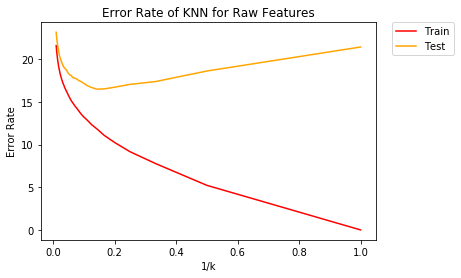

In [186]:
plt.plot(invert_k ,train_errors, color = 'red',label = 'Train')
plt.plot(invert_k ,test_errors, color = 'orange',label = 'Test')
plt.title('Error Rate of KNN for Raw Features')
plt.xlabel('1/k')
plt.ylabel('Error Rate')
plt.legend(bbox_to_anchor = [1.05,1],loc = 2,borderaxespad = 0)

index = test_errors.index(min(test_errors))
print('The best fit is at k = %d with a test error of %.02f.' %(k_values[index], min(test_errors)))

MSE_df.loc[4] = ['Raw KNN - Train', round(min(train_errors),3)]
MSE_df.loc[5] = ['Raw KNN - Test', round(min(test_errors),3)]

### Normalized Features:

In [187]:
norm_df = df[['T', 'V', 'AP', 'RH']]
x = norm_df.values
min_max_scaler = preprocessing.MinMaxScaler() # Use sklearn MinMaxScaler() to normalize features
x_scaled = min_max_scaler.fit_transform(x)
norm_df = pd.DataFrame(x_scaled)
norm_df.columns = ['T', 'V', 'AP', 'RH']
norm_df.head()

,T,V,AP,RH
0,0.372521,0.291815,0.771591,0.638204
1,0.662040,0.669039,0.671863,0.449330
2,0.093484,0.249822,0.476862,0.892493
3,0.539660,0.568683,0.429349,0.684718
4,0.255241,0.216014,0.404355,0.952547


In [188]:
k_values = list(range(1,101))
train_errors = []
test_errors = []
x = norm_df[['T', 'V', 'AP', 'RH']]
y = df['EP']

X_train, X_test, y_train, y_test = train_test_split(x, y , test_size = 0.3, random_state = 25)

for k in k_values:
    knn = KNeighborsRegressor(k, metric = "euclidean")
    knn.fit(X_train, y_train)
    train_predict = knn.predict(X_train)
    test_predict = knn.predict(X_test)
    mse_train = metrics.mean_squared_error(y_train, train_predict)
    mse_test = metrics.mean_squared_error(y_test, test_predict)
    
    train_errors.append(mse_train)
    test_errors.append(mse_test)

invert_k = [1 / x for x in k_values]

The best fit is at k = 6 with a test error of 14.96.


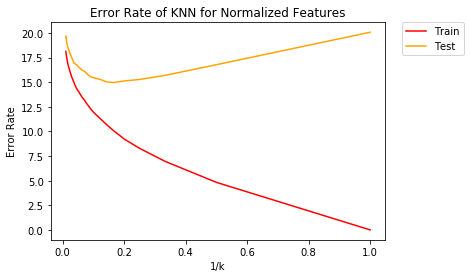

In [189]:
plt.plot(invert_k ,train_errors, color = 'red',label = 'Train')
plt.plot(invert_k ,test_errors, color = 'orange',label = 'Test')
plt.title('Error Rate of KNN for Normalized Features')
plt.xlabel('1/k')
plt.ylabel('Error Rate')
plt.legend(bbox_to_anchor = [1.05,1],loc = 2,borderaxespad = 0)

index = test_errors.index(min(test_errors))
print('The best fit is at k = %d with a test error of %0.2f.' %(k_values[index], min(test_errors)))

MSE_df.loc[6] = ['Normalized KNN - Train', round(min(train_errors),3)]
MSE_df.loc[7] = ['Normalized KNN - Test', round(min(test_errors),3)]

## (j) Compare the results of KNN Regression with linear regression

In [201]:
MSE_df

,Model,MSE
0,Multiple Linear Regression - Train,20.466
1,Multiple Linear Regression - Test,21.476
2,Full Linear Regression with All Interaction Te...,17.479
3,Full Linear Regression with All Interaction Te...,18.305
4,Raw KNN - Train,0.000
5,Raw KNN - Test,16.480
6,Normalized KNN - Train,0.000
7,Normalized KNN - Test,14.965


## See Report for Problems 2 and 3